Translate datasetnya dulu baru di train

Load data

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
path = "/content/drive/MyDrive/capstone/ml code (celia iseng)/describe/Symptom2Disease.csv"
df = pd.read_csv(path)

In [3]:
df

,Unnamed: 0,label,text
0,0,Psoriasis,I have been experiencing a skin rash on my arm...
1,1,Psoriasis,"My skin has been peeling, especially on my kne..."
2,2,Psoriasis,I have been experiencing joint pain in my fing...
3,3,Psoriasis,"There is a silver like dusting on my skin, esp..."
4,4,Psoriasis,"My nails have small dents or pits in them, and..."
...,...,...,...
1195,295,diabetes,I'm shaking and trembling all over. I've lost ...
1196,296,diabetes,"Particularly in the crevices of my skin, I hav..."
1197,297,diabetes,I regularly experience these intense urges and...
1198,298,diabetes,"I have trouble breathing, especially outside. ..."


In [4]:
text_en = df['text'].values.tolist()

translate description

In [5]:
!pip install deep-translator

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [6]:
from deep_translator import GoogleTranslator
text_in = []
for i in range(len(text_en)):
  text_in.append(GoogleTranslator(source='english', target='indonesian').translate(text_en[i]))
text_in

['Saya telah mengalami ruam kulit di lengan, kaki, dan dada saya selama beberapa minggu terakhir. Warnanya merah, gatal, dan tertutup bercak kering bersisik.',
 'Kulit saya mengelupas, terutama di lutut, siku, dan kulit kepala. Pengelupasan ini sering disertai dengan sensasi terbakar atau menyengat.',
 'Saya telah mengalami nyeri sendi di jari, pergelangan tangan, dan lutut. Sakitnya sering pegal dan berdenyut, dan semakin parah saat saya menggerakkan persendian.',
 'Ada debu seperti perak di kulit saya, terutama di punggung bawah dan kulit kepala. Debu ini terdiri dari sisik-sisik kecil yang mudah mengelupas saat saya menggaruknya.',
 'Kuku saya memiliki penyok atau lubang kecil di dalamnya, dan sering terasa meradang dan lunak saat disentuh. Bahkan ada ruam kecil di lengan saya.',
 'Kulit di telapak tangan dan kaki saya menebal dan retakan yang dalam. Retakan ini menyakitkan dan mudah berdarah.',
 'Kulit di sekitar mulut, hidung, dan mata saya merah dan meradang. Seringkali terasa ga

Labeling sentence, train test split, padding

In [7]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
def label_encode(labels):
    label_encoder.fit(labels)
    label_sequences = label_encoder.transform(labels)
    return label_sequences

df['label_encoded'] = label_encode(df['label'])

In [8]:
labels = df['label_encoded'].values.tolist()

In [9]:
print(type(text_in))
print(type(labels))

<class 'list'>
<class 'list'>


In [10]:
from sklearn.model_selection import train_test_split
train_sentences,validation_sentences,train_labels,validation_labels = train_test_split(text_in,labels, test_size = 0.2, random_state=1)

In [11]:
print()

In [12]:
vocab_size = 1500
embedding_dim = 16
max_length = 120
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_portion = .8

In [13]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import layers, models, optimizers

In [14]:
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(train_sentences)
word_index = tokenizer.word_index

train_sequences = tokenizer.texts_to_sequences(train_sentences)
train_padded = pad_sequences(train_sequences, padding=padding_type, maxlen=max_length)

validation_sequences = tokenizer.texts_to_sequences(validation_sentences)
validation_padded = pad_sequences(validation_sequences, padding=padding_type, maxlen=max_length)

print(type(train_padded))
print(type(validation_padded))
print(validation_padded)

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
[[  2  22 452 ...   0   0   0]
 [  2 297 312 ...   0   0   0]
 [295  92   2 ...   0   0   0]
 ...
 [ 36   2 212 ...   0   0   0]
 [  2   6  18 ...   0   0   0]
 [  2  22   6 ...   0   0   0]]


create model and train

In [15]:
def create_model(vocab_size, embedding_dim, max_length):
  model = models.Sequential([
  layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
  layers.GlobalAveragePooling1D(),
  layers.Dense(24, activation='relu'),
  layers.Dense(24, activation='softmax')
  ])

  model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                optimizer=optimizers.Adam(),
                metrics=['accuracy'])
  
  return model

In [16]:
model = create_model(vocab_size, embedding_dim, max_length)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 120, 16)           24000     
                                                                 
 global_average_pooling1d (G  (None, 16)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 24)                408       
                                                                 
 dense_1 (Dense)             (None, 24)                600       
                                                                 
Total params: 25,008
Trainable params: 25,008
Non-trainable params: 0
_________________________________________________________________


In [17]:
train_labels = np.array(train_labels)
validation_labels = np.array(validation_labels)

In [18]:
train_labels = train_labels.reshape(len(train_labels), 1)
validation_labels = validation_labels.reshape(len(validation_labels), 1)

In [19]:
num_epochs = 100
history = model.fit(train_padded, train_labels, 
                    epochs=num_epochs, 
                    validation_data=(validation_padded, validation_labels))

Epoch 1/100
30/30 [==============================] - 1s 9ms/step - loss: 3.1777 - accuracy: 0.0448 - val_loss: 3.1770 - val_accuracy: 0.0292
Epoch 2/100
30/30 [==============================] - 0s 2ms/step - loss: 3.1739 - accuracy: 0.0479 - val_loss: 3.1745 - val_accuracy: 0.0292
Epoch 3/100
30/30 [==============================] - 0s 2ms/step - loss: 3.1695 - accuracy: 0.0677 - val_loss: 3.1712 - val_accuracy: 0.0500
Epoch 4/100
30/30 [==============================] - 0s 2ms/step - loss: 3.1640 - accuracy: 0.1083 - val_loss: 3.1667 - val_accuracy: 0.0708
Epoch 5/100
30/30 [==============================] - 0s 3ms/step - loss: 3.1559 - accuracy: 0.1510 - val_loss: 3.1595 - val_accuracy: 0.0833
Epoch 6/100
30/30 [==============================] - 0s 2ms/step - loss: 3.1445 - accuracy: 0.1469 - val_loss: 3.1491 - val_accuracy: 0.0917
Epoch 7/100
30/30 [==============================] - 0s 2ms/step - loss: 3.1273 - accuracy: 0.1677 - val_loss: 3.1343 - val_accuracy: 0.1042
Epoch 8/100
3

In [20]:
import matplotlib.pyplot as plt

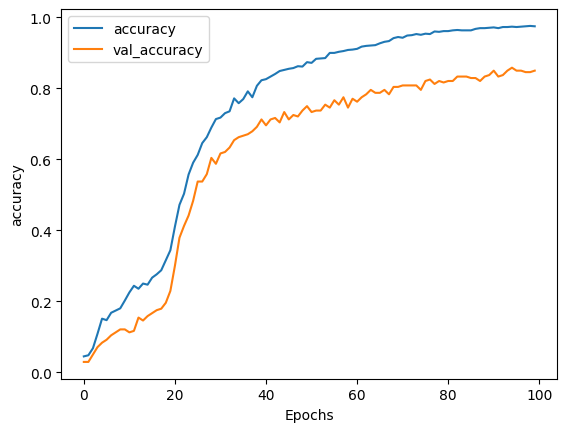

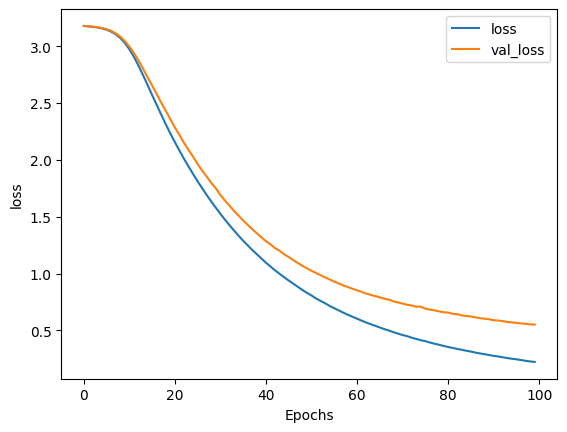

In [21]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [22]:
filepath = "/content/drive/MyDrive/capstone/ml code (celia iseng)/describe/model_translate.h5"

In [23]:
model.save(filepath, save_format='h5')

In [24]:
!pip install tensorflowjs

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.1/85.1 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 189.9/189.9 kB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 93.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.9/40.9 kB 4.8 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 23.1
    Uninstalling packaging-23.1:
      Successfully uninstalled packaging-23.1
  Attempting uninstall: flax
    Found existing installation: flax 0.6.9
    Uninstalling flax-0.6.9:
      Successfully uninstalled flax-0.6.9
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
statsmodels 0.13.5 requires packaging>=21.3, but you have packaging 20.9 which is incompatible.
xar

In [25]:
import tensorflowjs as tfjs

In [26]:
tfjs.converters.save_keras_model(model, "/content/drive/MyDrive/capstone/ml code (celia iseng)/")

In [27]:
#word_index = tokenizer.word_index

In [28]:
#index_to_word = {index: word for word, index in word_index.items()}

In [29]:
#dict_input = pd.DataFrame.from_dict(index_to_word, orient='index', columns=['Word'])

In [30]:
#csv_filename = '/content/drive/MyDrive/capstone/ml code (celia iseng)/describe/dict_input_in.csv'
#dict_input.to_csv(csv_filename)

In [31]:
#label_mapping = {label: encoded_label for label, encoded_label in zip(df['label'].tolist(),labels)}

In [32]:
#dict_output = pd.DataFrame.from_dict(label_mapping, orient='index', columns=['EncodedLabel'])
#dict_output.index.name = 'OriginalLabel'

In [33]:
#csv_filename = '/content/drive/MyDrive/capstone/ml code (celia iseng)/describe/dict_output_in.csv'
#dict_output.to_csv(csv_filename)

In [34]:
test = ["Saya mengalami demam tinggi yang mendadak, disertai dengan nyeri pada tulang dan otot. Saya juga merasa sangat lelah dan kehilangan nafsu makan. Saya mengalami sakit kepala yang parah, terutama di belakang mata. Saya mengalami pendarahan ringan dari hidung atau gusi, serta muncul ruam merah pada kulit.", "Saya ingin berkonsultasi tentang kondisi kesehatan saya. Saya merasa sangat lelah, demam tinggi, mengalami nyeri di seluruh tubuh, serta sakit kepala parah. Saya juga memiliki ruam pada kulit saya. Apakah Anda dapat membantu saya menentukan penyebab dan memberikan perawatan yang sesuai?", "Saya ingin berkonsultasi tentang kondisi kesehatan saya. Saya merasa sangat lelah, mengalami demam tinggi, menggigil, dan batuk yang parah. Saya juga merasakan sesak napas dan nyeri dada yang intens. Saya khawatir bahwa saya mungkin mengidap pneumonia. Bisakah Anda membantu menentukan diagnosis dan memberikan perawatan yang tepat?", "Saya ingin berkonsultasi tentang kondisi kesehatan saya. Saya memiliki beberapa gejala yang mengkhawatirkan terkait gula darah saya. Saya sering merasa sangat haus dan sering buang air kecil. Saya juga merasakan kelelahan yang berlebihan, berat badan saya naik-turun tanpa alasan yang jelas, dan kesemutan pada tangan dan kaki saya. Saya khawatir bahwa saya mungkin mengidap diabetes. Apakah Anda dapat membantu saya menentukan diagnosis dan memberikan perawatan yang tepat?"]

In [35]:
test_sequences = tokenizer.texts_to_sequences(test)
test_padded = pad_sequences(test_sequences, padding=padding_type, maxlen=max_length)

In [36]:
prediction = model.predict_on_batch(
    test_padded
)

In [37]:
for i in prediction:
  top_3 = np.argsort(i)[-1:]
  print(label_encoder.inverse_transform(top_3))
  print(top_3)

['Dengue']
[6]
['Chicken pox']
[4]
['Bronchial Asthma']
[2]
['peptic ulcer disease']
[22]
